# Bagging

This notebook implements bagging, or bootstrap aggregating. It is an ensemble method used to reduce variance and avoid overfitting while improving the stability and accuracy of algorithms. It is usually applied to decision tree methods, but can be used with any type of method.

Bootstrapping is a resampling method that involves random sampling with replacement to obtain measures of accuracy to sample estimates.

---

First, load the relevant libraries needed.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Import functions to help with training/testing endeavors and evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Import classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

## The Data

The model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [4]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


## Performing Bagging

I will perform bagging for binary classification. At first, I try to perform this algorithm to classify all 3 hawk species in my data, but I get the following error because the model fails to identify any Cooper's hawks:

```
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
```

Instead, I will classify a hawk as red-tailed vs. not red-tailed.

In [48]:
# Data preparation step
X = hawks[["Wing", "Tail"]].to_numpy()
# Convert each entry of y with RT (red-tailed) to -1 and otherwise 1
hawks["Species_binary"] = [1 if x == "RT" else -1 for x in hawks.Species]
y = hawks["Species_binary"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

### Train a decision stump

In [49]:
stump_clf = DecisionTreeClassifier(max_depth=1, random_state=42)
stump_clf.fit(X_train, y_train)
stump_y_pred = stump_clf.predict(X_test)
print(f"Stump Classification Report")
print(classification_report(y_test, stump_y_pred), "\n")

Stump Classification Report
              precision    recall  f1-score   support

          -1       1.00      0.97      0.99        73
           1       0.98      1.00      0.99       106

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179
 



In [69]:
def plot_binary_decision_regions(clf):
    # Plot the training and testing observations with decision regions overlaid
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    fig.suptitle("Red-tailed vs. Not Red-tailed Hawk Decision Region Plot", fontsize = 14)
    fig = plot_decision_regions(X_train, y_train, clf = clf, ax = axes[0], legend = 2)
    axes[0].set_xlim((40, 480))
    axes[0].set_ylim((120, 265))
    axes[0].set_title("Training Dataset", fontsize = 13)
    axes[0].set_xlabel("Wing length [mm]", fontsize = 11)
    axes[0].set_ylabel("Tail length [mm]", fontsize = 11)

    fig = plot_decision_regions(X_test, y_test, clf = clf, ax = axes[1], legend = 2)
    axes[1].set_xlim((40, 480))
    axes[1].set_ylim((120, 265))
    axes[1].set_title("Testing Dataset", fontsize = 13)
    axes[1].set_xlabel("Wing length [mm]", fontsize = 11)
    axes[1].set_ylabel("Tail length [mm]", fontsize = 11)

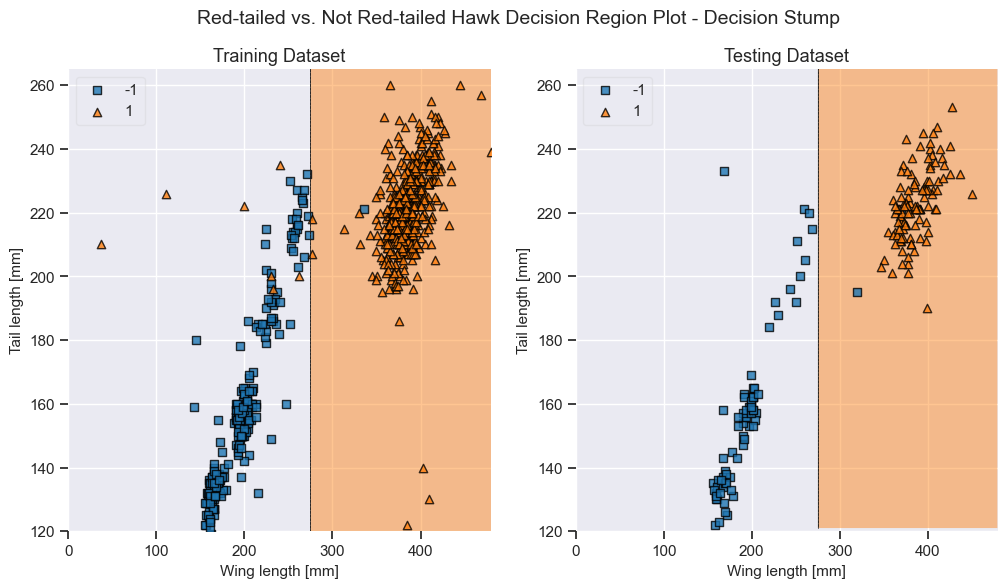

In [66]:
plot_binary_decision_regions(stump_clf)
plt.suptitle("Red-tailed vs. Not Red-tailed Hawk Decision Region Plot - Decision Stump", fontsize = 14)
plt.show()

### Perform bagging on decision stump

In [40]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=1, random_state=42),
                            n_estimators = 1000,
                            bootstrap = True,
                            n_jobs = -1)
bag_clf.fit(X_train, y_train)
bag_y_pred = bag_clf.predict(X_test)
print(f"Bagging Classification Report")
print(classification_report(y_test, bag_y_pred), "\n")

Bagging Classification Report
              precision    recall  f1-score   support

          -1       1.00      0.97      0.99        73
           1       0.98      1.00      0.99       106

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179
 



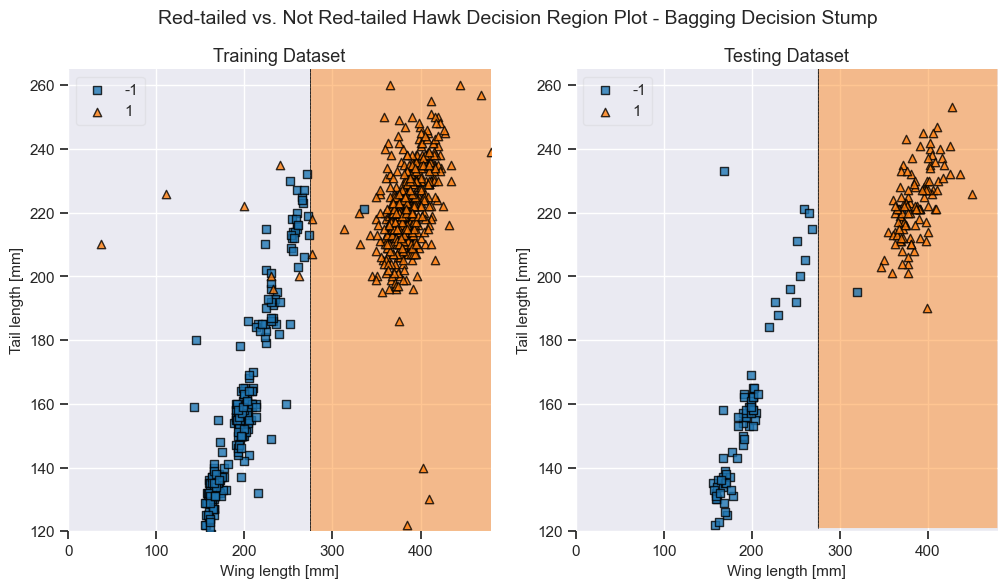

In [67]:
plot_binary_decision_regions(bag_clf)
plt.suptitle("Red-tailed vs. Not Red-tailed Hawk Decision Region Plot - Bagging Decision Stump", fontsize = 14)
plt.show()

### Train a decision tree to compare

In [57]:
tree_clf = DecisionTreeClassifier(max_depth=6, random_state=42)
tree_clf.fit(X_train, y_train)
tree_y_pred = tree_clf.predict(X_test)
print(f"Tree Classification Report")
print(classification_report(y_test, tree_y_pred), "\n")

Tree Classification Report
              precision    recall  f1-score   support

          -1       0.99      0.93      0.96        73
           1       0.95      0.99      0.97       106

    accuracy                           0.97       179
   macro avg       0.97      0.96      0.96       179
weighted avg       0.97      0.97      0.97       179
 



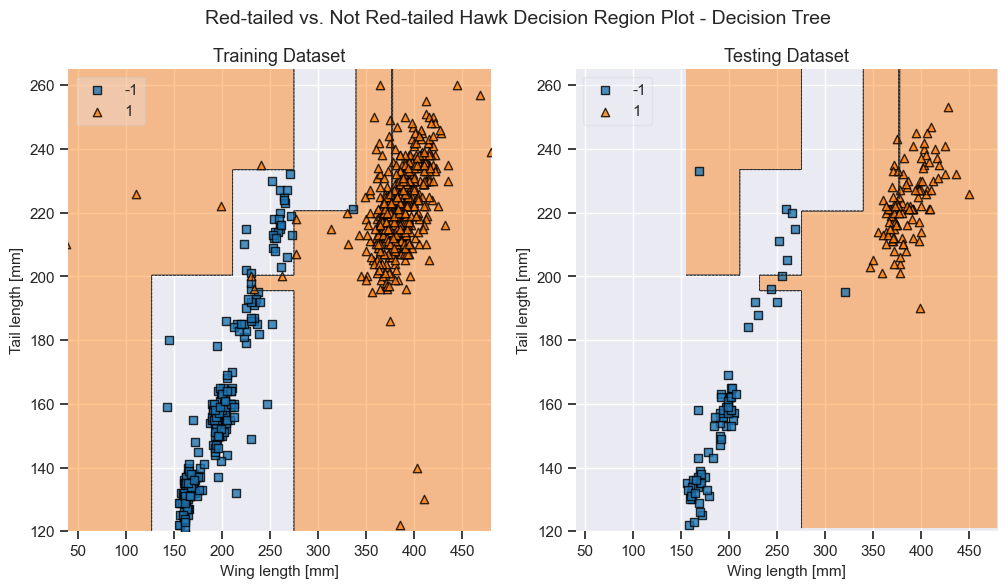

In [70]:
plot_binary_decision_regions(tree_clf)
plt.suptitle("Red-tailed vs. Not Red-tailed Hawk Decision Region Plot - Decision Tree", fontsize = 14)
plt.show()

### Train a random forest to compare